SUMMARY & USAGE LICENSE
=============================================

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under the following conditions:

     * The user may not state or imply any endorsement from the
       University of Minnesota or the GroupLens Research Group.

     * The user must acknowledge the use of the data set in
       publications resulting from the use of the data set
       (see below for citation information).

     * The user may not redistribute the data without separate
       permission.

     * The user may not use this information for any commercial or
       revenue-bearing purposes without first obtaining permission
       from a faculty member of the GroupLens Research Project at the
       University of Minnesota.

If you have any further questions or comments, please contact GroupLens
<grouplens-info@cs.umn.edu>. 

CITATION
==============================================

To acknowledge use of the dataset in publications, please cite the
following paper:

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets:
History and Context. ACM Transactions on Interactive Intelligent
Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages.
DOI=http://dx.doi.org/10.1145/2827872

ACKNOWLEDGEMENTS
==============================================

Thanks to Al Borchers for cleaning up this data and writing the
accompanying scripts.

PUBLISHED WORK THAT HAS USED THIS DATASET
==============================================

Herlocker, J., Konstan, J., Borchers, A., Riedl, J.. An Algorithmic
Framework for Performing Collaborative Filtering. Proceedings of the
1999 Conference on Research and Development in Information
Retrieval. Aug. 1999.

FURTHER INFORMATION ABOUT THE GROUPLENS RESEARCH PROJECT
==============================================

The GroupLens Research Project is a research group in the Department
of Computer Science and Engineering at the University of Minnesota.
Members of the GroupLens Research Project are involved in many
research projects related to the fields of information filtering,
collaborative filtering, and recommender systems. The project is lead
by professors John Riedl and Joseph Konstan. The project began to
explore automated collaborative filtering in 1992, but is most well
known for its world wide trial of an automated collaborative filtering
system for Usenet news in 1996.  The technology developed in the
Usenet trial formed the base for the formation of Net Perceptions,
Inc., which was founded by members of GroupLens Research. Since then
the project has expanded its scope to research overall information
filtering solutions, integrating in content-based methods as well as
improving current collaborative filtering technology.

Further information on the GroupLens Research project, including
research publications, can be found at the following web site:
        
        http://www.grouplens.org/

GroupLens Research currently operates a movie recommender based on
collaborative filtering:

        http://www.movielens.org/

DETAILED DESCRIPTIONS OF DATA FILES
==============================================

Here are brief descriptions of the data.

ml-data.tar.gz   -- Compressed tar file.  To rebuild the u data files do this:
                gunzip ml-data.tar.gz
                tar xvf ml-data.tar
                mku.sh

u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC   

u.info     -- The number of users, items, and ratings in the u data set.

u.item     -- Information about the items (movies); this is a tab separated
              list of
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.

u.genre    -- A list of the genres.

u.user     -- Demographic information about the users; this is a tab
              separated list of
              user id | age | gender | occupation | zip code
              The user ids are the ones used in the u.data data set.

u.occupation -- A list of the occupations.

u1.base    -- The data sets u1.base and u1.test through u5.base and u5.test
u1.test       are 80%/20% splits of the u data into training and test data.
u2.base       Each of u1, ..., u5 have disjoint test sets; this if for
u2.test       5 fold cross validation (where you repeat your experiment
u3.base       with each training and test set and average the results).
u3.test       These data sets can be generated from u.data by mku.sh.
u4.base
u4.test
u5.base
u5.test

ua.base    -- The data sets ua.base, ua.test, ub.base, and ub.test
ua.test       split the u data into a training set and a test set with
ub.base       exactly 10 ratings per user in the test set.  The sets
ub.test       ua.test and ub.test are disjoint.  These data sets can
              be generated from u.data by mku.sh.

allbut.pl  -- The script that generates training and test sets where
              all but n of a users ratings are in the training data.

mku.sh     -- A shell script to generate all the u data sets from u.data.

#Read in data file



In [ ]:
import os
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import argparse
import scipy.sparse as sparse
from scipy.sparse import save_npz, load_npz
from scipy.sparse import csr_matrix

In [ ]:
#need to upload the zip file onto the colab session first
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
replace ml-100k/u.item? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


In [ ]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [ ]:
def getDF(dataset, file_name):
    #retrieve the required file from the zip file
    #this function only works for data files that contain the ratings since we're specifying the header names here.
    header_names = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(dataset, file_name), sep='\t', names=header_names)
    return data 

In [ ]:
#u.data is the file that contains all rating data.

rating_df = getDF(MOVIELENS_DIR, 'u.data')

In [ ]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


# Histograms

In [ ]:
def getHistogram(df,measure,title,xlabel, ylabel, bins):
    plt.hist(df[measure].values, align='mid', bins = bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    fig = plt.gcf()

## Histogram of Ratings

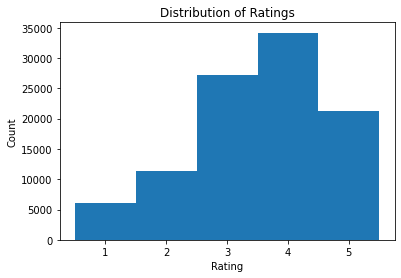

In [ ]:
#plot a histogram of the frequency of ratings for each rating value.
getHistogram(rating_df,'rating','Distribution of Ratings','Rating','Count', [0.5,1.5,2.5,3.5,4.5,5.5])

In [ ]:
#look at number of users and number of items

print('number of unique users = ', len(set(rating_df['userID'].values)))
print('number of unique items = ', len(set(rating_df['itemID'].values)))

number of unique users =  943
number of unique items =  1682


## Number of ratings available per user

In [ ]:
#look at the number of ratings each user has rated
ratings_per_user = {}

for u in rating_df['userID'].values:
    ratings = rating_df[rating_df.userID == u]
    ratings_per_user[u] = [len(ratings), sum(ratings['rating'].values) / len(ratings['rating'].values)]

min # of reviews available per user =  20
max # of reviews available per user =  737


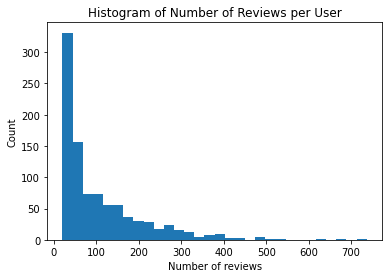

In [ ]:
df_users_rating_counts = pd.DataFrame.from_dict(ratings_per_user, orient = 'index', columns = ['number of reviews','average rating'])

#histogram of the frequency of the number of reviews available per user
getHistogram(df_users_rating_counts,'number of reviews','Histogram of Number of Reviews per User', 'Number of reviews', 'Count',bins = 30)

print("min # of reviews available per user = ", min(df_users_rating_counts['number of reviews'].values))
print("max # of reviews available per user = ", max(df_users_rating_counts['number of reviews'].values))

From the histgram of the number of reviews available per user, we see that over 500 users (over half of the total number of reviewers) have \<100 reviews.

## Average rating by users

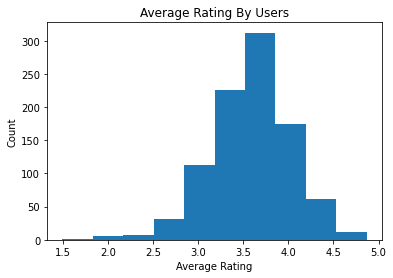

In [ ]:
#histogram of the frequency of the number of reviews available per user
getHistogram(df_users_rating_counts,'average rating','Average Rating By Users', 'Average Rating', 'Count',bins = 10)


From the histogram above we see that the average rating for most users is between 3 and 4. 


##Number of ratings available per item


In [ ]:
#look at the number of ratings each user has rated
ratings_per_item = {}
for i in rating_df['itemID'].values:
    ratings = rating_df[rating_df.itemID == i]
    ratings_per_item[i] = [len(rating_df[rating_df.itemID == i]), sum(ratings['rating'].values) / len(ratings['rating'].values)]


min # of reviews available per item =  1
max # of reviews available per item =  583


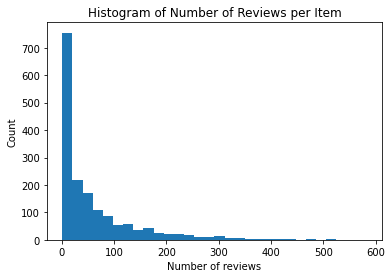

In [ ]:
df_item_rating_counts = pd.DataFrame.from_dict(ratings_per_item, orient = 'index', columns = ['number of reviews','average rating'])

#histogram of the frequency of the number of reviews available per user
getHistogram(df_item_rating_counts,'number of reviews','Histogram of Number of Reviews per Item', 'Number of reviews', 'Count', 30)
print("min # of reviews available per item = ", min(df_item_rating_counts['number of reviews'].values))
print("max # of reviews available per item = ", max(df_item_rating_counts['number of reviews'].values))

In [ ]:
print("number of items with 1 review:")
print(sum(df_item_rating_counts['number of reviews'].values==1))

print("\nnumber of items with <5 reviews:")
print(sum(df_item_rating_counts['number of reviews'].values<=5))

number of items with 1 review:
141

number of items with <5 reviews:
384


since number of unique items =  1682

from the histogram above we see that the majority of items have less than 100 reviews, a small number of items have 100-200 reviews, and only a few have more than 200 reviews.

## Average rating by items


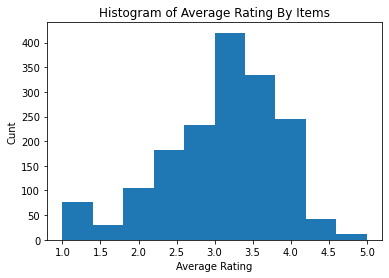

In [ ]:
#histogram of the frequency of the number of reviews available per user
getHistogram(df_item_rating_counts,'average rating','Histogram of Average Rating By Items', 'Average Rating', 'Cunt',bins = 10)


# Read data files into sparse martices 


In [ ]:
#save dataframe to file for loading into a sparse matrix later
rating_df.columns = ['userId', 'movieId', 'rating', 'timestamp']
rating_df.to_csv("100K_ratings.csv", index=False)

In [ ]:
def time_ordered_split(rating_matrix, timestamp_matrix, ratio=[0.5, 0.2, 0.3]):

    """
    #if we want to predict if a user will like a movie, threshold the data at 3
    temp_rating_matrix = sparse.csr_matrix(rating_matrix.shape)
    temp_rating_matrix[(rating_matrix > 3).nonzero()] = 1
    rating_matrix = temp_rating_matrix
    timestamp_matrix = timestamp_matrix.multiply(rating_matrix)
    """

    temp_rating_matrix = sparse.csr_matrix(rating_matrix.shape)
    temp_rating_matrix[rating_matrix.nonzero()] = 1
    rating_matrix = temp_rating_matrix
    nonzero_index = None

    # Remove empty columns. record original item index
    nonzero_index = np.unique(rating_matrix.nonzero()[1])
    rating_matrix = rating_matrix[:, nonzero_index]
    timestamp_matrix = timestamp_matrix[:, nonzero_index]

    # Remove empty rows. record original user index
    nonzero_rows = np.unique(rating_matrix.nonzero()[0])
    rating_matrix = rating_matrix[nonzero_rows]
    timestamp_matrix = timestamp_matrix[nonzero_rows]


    rtrain = []
    rtime = []
    rvalid = []
    rtest = []

    #iterate through each user and add entries to train, validation and test sets based on the time 
    #that each review was created
    for i in range(rating_matrix.shape[0]):  #number of users
        #for user i, get the indices of items rated, the rating values, and time stamps.
        item_indexes = rating_matrix[i].nonzero()[1]
        item_ratings = rating_matrix[i].data
        timestamp = timestamp_matrix[i].data

        #get the proportion of test size and validation size based on the number of items user i rated 
        num_items_rated = len(item_indexes)
        num_test = int(num_items_rated * ratio[2])
        num_valid = int(num_items_rated * (ratio[1] + ratio[2]))

        #get offset values for validation and test data indices
        valid_offset = num_items_rated - num_valid
        test_offset = num_items_rated - num_test

        #sort the items rated by user i based on timestamps
        item_ratings = item_ratings[np.argsort(timestamp)]
        item_indexes = item_indexes[np.argsort(timestamp)]

        #add the items and their ratings to the train/validation/test data based on timestamps (oldest --> newest)
        #we only train on historic data, then validate on future data, and test on data farther in the future.
        rtrain.append([item_ratings[:valid_offset], np.full(valid_offset, i), item_indexes[:valid_offset]])
        rvalid.append([item_ratings[valid_offset:test_offset], np.full(test_offset - valid_offset, i),
                        item_indexes[valid_offset:test_offset]])
        rtest.append([item_ratings[test_offset:], np.full(num_test, i), item_indexes[test_offset:]])

    rtrain = np.array(rtrain)
    rvalid = np.array(rvalid)
    rtest = np.array(rtest)

    #create sparse matrices 
    rtrain = sparse.csr_matrix((np.hstack(rtrain[:, 0]), (np.hstack(rtrain[:, 1]), np.hstack(rtrain[:, 2]))),
                               shape=rating_matrix.shape, dtype=np.float32)
    rvalid = sparse.csr_matrix((np.hstack(rvalid[:, 0]), (np.hstack(rvalid[:, 1]), np.hstack(rvalid[:, 2]))),
                               shape=rating_matrix.shape, dtype=np.float32)
    rtest = sparse.csr_matrix((np.hstack(rtest[:, 0]), (np.hstack(rtest[:, 1]), np.hstack(rtest[:, 2]))),
                              shape=rating_matrix.shape, dtype=np.float32)

    print("\ndata files saved!")
    return rtrain, rvalid, rtest, nonzero_index, timestamp_matrix

In [ ]:
#load matrix of ratings and matrix of timestamps
ratings_100k_df = pd.read_csv("100K_ratings.csv")
rating_matrix = csr_matrix((ratings_100k_df["rating"], (ratings_100k_df['userId'], ratings_100k_df['movieId'])))
timestamp_matrix = csr_matrix((ratings_100k_df["timestamp"], (ratings_100k_df['userId'], ratings_100k_df['movieId'])))

#retrive data files based on 50/20/30 split
rtrain, rvalid, rtest, nonzero_index, rtime = time_ordered_split(rating_matrix=rating_matrix,
                                                                    timestamp_matrix=timestamp_matrix,
                                                                    ratio=[0.5, 0.2, 0.3]) #train, validation and test ratio

#save all data files
save_npz("Rtrain", rtrain)
save_npz("Rvalid", rvalid)
save_npz("Rtest", rtest)
np.save("Index", nonzero_index)
save_npz("Rtime", rtime)

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)



data files saved!
